In [2]:
!pip install pandas

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_excel("input/insurance.xlsx")
#data.head()

In [4]:
#data.shape
#data.info()

Check the feature correlations

<AxesSubplot:>

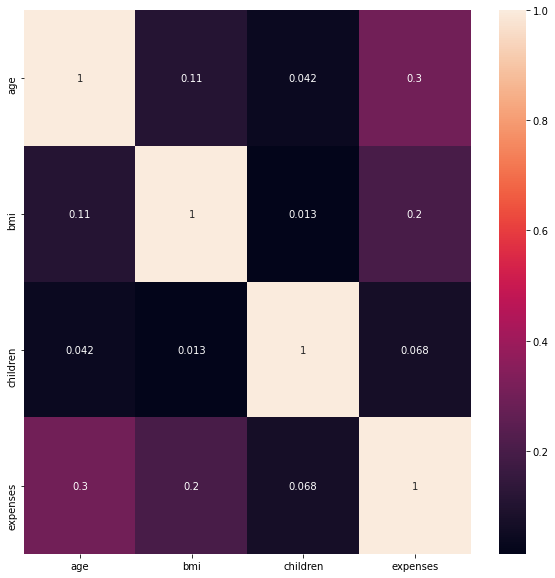

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
corr = data.corr()
sns.heatmap(corr , annot = True , ax=ax)

Label Encode Object Types

In [6]:
d_types = dict(data.dtypes)
for name , type_ in d_types.items():
    if str(type_) == 'object':
        print(f"======== {name} ===========")
        print(data[name].value_counts())

======== sex ===========
male      676
female    662
Name: sex, dtype: int64
======== smoker ===========
no     1064
yes     274
Name: smoker, dtype: int64
======== region ===========
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

for name , type_ in d_types.items():
    if str(type_) == 'object':
        Le = LabelEncoder()
        data[name] = Le.fit_transform(data[name])

One hot Encoding 

In [8]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
part = onehotencoder.fit_transform(data['region'].values.reshape(-1,1)).toarray()

values = dict(data["region"].value_counts())

for e , (val , _) in enumerate(values.items()):
    data["region_" + str(val)] = part[:,e]

data = data.drop(["region"] , axis = 1)

data.head()
#data.info()

,age,sex,bmi,children,smoker,expenses,region_2,region_3,region_1,region_0
0,19,0,27.9,0,1,16884.92,0.0,0.0,0.0,1.0
1,18,1,33.8,1,0,1725.55,0.0,0.0,1.0,0.0
2,28,1,33.0,3,0,4449.46,0.0,0.0,1.0,0.0
3,33,1,22.7,0,0,21984.47,0.0,1.0,0.0,0.0
4,32,1,28.9,0,0,3866.86,0.0,1.0,0.0,0.0


Make Features and Targets

In [9]:
remaining_columns = list(data.columns)
remaining_columns.remove("expenses")

X = data[remaining_columns].values 
Y = data['expenses'].values

from sklearn.model_selection import train_test_split 
Xtrain , Xtest , Ytrain , Ytest = train_test_split(X , Y , test_size = 0.2 , random_state = 4)

from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Xtrain = Scaler.fit_transform(Xtrain)
Xtest = Scaler.transform(Xtest)

Xtrain.shape , Xtest.shape

((1070, 9), (268, 9))

## 正規化 check whether data is standardized (mean should be 1)

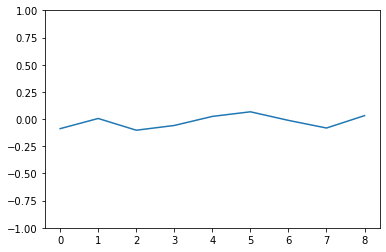

In [10]:
plt.ylim(-1,1)
means = []
for i in range(X.shape[1]):
    means.append(np.mean(Xtest[:,i]))
plt.plot(means , scaley=False)

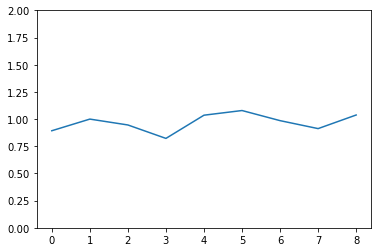

In [11]:
# Check variances 
plt.ylim(0,2)
vars = []
for i in range(X.shape[1]):
    vars.append(np.var(Xtest[:,i]))
plt.plot(vars)

## Recursive Feature Elimination (RFECV) 遞歸特徵消除：特徵擷取的一種方法

通過交叉驗證來找到最優的特徵數量。如果減少特徵會造成性能損失，那麼將不會去除任何特徵。這個方法用以選取單模型特徵相當不錯，但是有兩個缺陷，一，計算量大。二，隨著學習器（評估器）的改變，最佳特徵組合也會改變，有些時候會造成不利影響。

- 對要訓練的機器學習算法進行建模
- 確定在一次迭代中要消除的特徵數量。
- 由於 RFECV 是遞歸迭代的，我們需要強行停止它。

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

#特徵選取
model = LinearRegression()
rfecv = RFECV(model , step = 1, min_features_to_select = 4 , n_jobs = -1) #每次去除特徵數  #最小特徵數
rfecv.fit(Xtrain , Ytrain)
model.fit(Xtrain , Ytrain)

LinearRegression()

In [19]:
selected_features = np.where(rfecv.support_)[0]
Xtrain = Xtrain[:,selected_features]
Xtest = Xtest[:,selected_features]
model.score(Xtest , Ytest) #測試與驗證

0.692643973413932

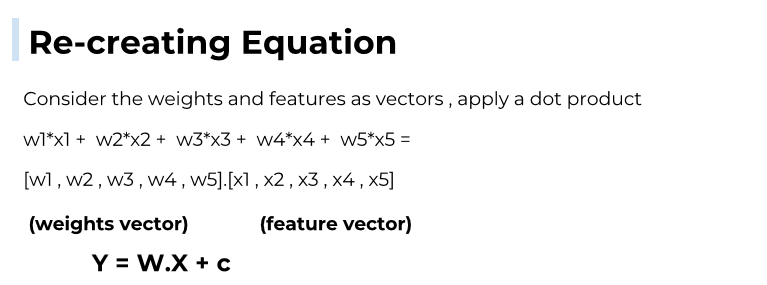

In [23]:
# Y = W.X + c
model.coef_.dot(Xtest[10,:]) + model.intercept_

3795.252501922945

In [17]:
model.predict(Xtest[10,:].reshape(1,-1))

array([3795.25250192])

In [13]:
# rfecv.support_  #保留排名
# rfecv.ranking_  #重要度排名
# model.coef_ # 可查看係數
# model.intercept_ # 可查看截距值